## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2022.

## **Task 2: RNN application -- Tweet Sentiment Analysis** (50%)

In this task, you are going to classify the sentiment in tweets into positive and negative using an LSTM model. The code to load the data and see its characteristics has been provided to you. 

In the first task, you will encode the data using one hot encoding and train an LSTM network to classify the sentiment. In the second task, you will replace the one hot encoding with an embedding layer and train another LSTM model. You will then extract the trained embeddings and visualize the word embeddings in 2 dimensions by using TSNE for dimensionality reduction. 

In [2]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import json
import time
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data


In [3]:
with open("./tweets_data/vocabulary.pkl", "rb") as f:
    vocabulary = pickle.load(f)

# load our data and separate it into tweets and labels
train_data = json.load(open('tweets_data/trainTweets_preprocessed.json', 'r'))
train_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),train_data))
train_tweets = np.array([t[0] for t in train_data])
train_labels = np.array([int(t[1]) for t in train_data])

test_data = json.load(open('tweets_data/testTweets_preprocessed.json', 'r'))
test_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),test_data))
test_tweets = np.array([t[0] for t in test_data])
test_labels = np.array([int(t[1]) for t in test_data])

print("size of original train set: {}".format(len(train_tweets)))
print("size of original test set: {}".format(len(test_tweets)))

# only select first 1000 test sample for test
test_tweets = test_tweets[:1000]
test_labels = test_labels[:1000]

print("*"*100)
print("size of train set: {}, #positive: {}, #negative: {}".format(len(train_tweets), np.sum(train_labels), len(train_tweets)-np.sum(train_labels)))
print("size of test set: {}, #positive: {}, #negative: {}".format(len(test_tweets), np.sum(test_labels), len(test_tweets)-np.sum(test_labels)))

# show text of the idx-th train tweet
# The 'padtoken' is used to ensure each tweet has the same length
idx = 100
train_text = [vocabulary[x] for x in train_tweets[idx]]
print(train_text)
sentiment_label = ["negative", "positive"]
print("sentiment: {}".format(sentiment_label[train_labels[idx]]))

size of original train set: 60000
size of original test set: 20000
****************************************************************************************************
size of train set: 60000, #positive: 30055, #negative: 29945
size of test set: 1000, #positive: 510, #negative: 490
['it', 'will', 'help', 'relieve', 'your', 'stress', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken']
sentiment: positive


## Part 1 LSTM Encoder (15%)

<font color="red"><strong>TODO:</strong></font> Create a single-layer LSTM network to classify tweets.
- Use one hot encoding to represent each word in the tweet.
- Set LSTM units to 128.
- Use Adam optimizer and set batch size to 32.

With these settings, what accuracy could you get? You can try to change some stuff in the network to see if you could get a better accuracy. 

<font color="red"><strong>Hint:</strong></font> tf.one_hot and Keras functional API may be useful.
<br>https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

In [4]:
###################################################
# TODO: Create a single-layer LSTM network.       #
#                                                 #
###################################################
from utils.rnn_utils import one_hot
batch_size = 32

vocab_len = len(vocabulary)
units = 128

model = tf.keras.Sequential()
model.add(tf.keras.layers.Lambda(lambda x: tf.one_hot(tf.cast(x, 'int32'), len(vocabulary)), input_shape=(20,), output_shape=(20, len(vocabulary))))
model.add(tf.keras.layers.LSTM(units))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics = tf.keras.metrics.BinaryAccuracy())
history = model.fit(train_tweets, train_labels, validation_data =(test_tweets, test_labels), 
                   epochs = 10, batch_size=batch_size)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 20, 7597)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               3955712   
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 3,955,841
Trainable params: 3,955,841
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1875/1875 [==============================] - 16s 7ms/step - loss: 0.5724 - binary_accuracy: 0.6943 - val_loss: 0.5101 - val_binary_accuracy: 0.7580
Epoch 2/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.4592 - binary_accuracy: 0.7860 - val_loss: 0.5036 - val_binary_accuracy: 0.7690
Epoch 3/10
1875/1875 [==============================] - 13

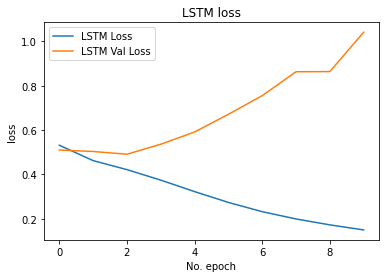

In [5]:
plt.plot(history.history['loss'], label='LSTM Loss')
plt.plot(history.history['val_loss'], label='LSTM Val Loss')
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

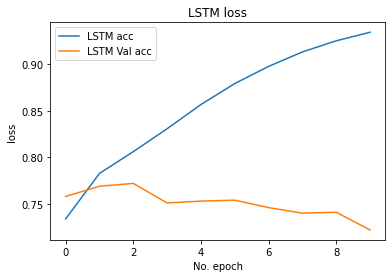

In [6]:
plt.plot(history.history['binary_accuracy'], label='LSTM acc')
plt.plot(history.history['val_binary_accuracy'], label='LSTM Val acc')
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

## Part 2: Embedding Lookup layer (20%)

### Define an embedding layer

It's not hard to imagine that in the previous practices, the input we fed in are very sparse because each word was represented as a one-hot vector. This makes it difficult for the network to understand what story the input data is telling. A useful technique is *Word Embedding*.

*Word Embedding*: instead of using a one-hot vector to represent each word, we can add a word embedding matrix in which each word is represented as a low-dimensional vector. Note that this representation is not sparse any more, because we're working in a continuous vector space now. Words that share similar/related semantic meaning should be 'close to each other' in this vector space (we could define a distance measure to estimate the closeness).

<font color="red"><strong>TODO:</strong></font> Define a similar model as above with some improvements.
- Use an Embedding layer instead of one hot embedding.
- Write a custom training loop to train the model instead of using model.fit().
- Write a custom loop gives you complete control over how the model is trained.
- Report loss and accuracy for training and validation after each epoch.
- Display the loss value after every 500 steps. 

Do you see any difference in accuracy? What about training time? What inference can you draw?

**Hints**: Refer to the link below.
<br>https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch


### Answer

- Accuracies are almost similar, and training time was a little slow. 
- It had to train an additional embedding layer's encodings, thus adding more parameters. The point of the embeddings is also to give each word a sense of context, so the LSTM should better understand the task with these word embeddings. 
- With more epochs, the model with an embedding layer will surpass the model with one-hot vectors, mainly because the dense representation allows it to store contexts far better than simple one-hot vectors.

In [7]:
###################################################
# TODO: Create a single-layer LSTM network        #
#       using Embedding layer                     #
###################################################

batch_size = 32
vocab_len = len(vocabulary)
units = 128
embed_dim = 128

# Training dataset pair
train_dataset = tf.data.Dataset.from_tensor_slices((train_tweets, train_labels))
train_dataset = train_dataset.batch(batch_size)

# Validation dataset pair
val_dataset = tf.data.Dataset.from_tensor_slices((test_tweets, test_labels))
val_dataset = val_dataset.batch(batch_size)

optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.BinaryCrossentropy()

inputs = tf.keras.Input((20,))
x = tf.keras.layers.Embedding(vocab_len, embed_dim, input_length=train_tweets.shape[1])(inputs)
x = tf.keras.layers.LSTM(units)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

model.summary()
train_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def val_step(x, y):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)

epochs = 10
for epoch in range(epochs):
    print("epoch: {}".format(epoch))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_value = train_step(x_batch_train, y_batch_train)

        # Print loss every 500 steps
        if step % 500 == 0:
            print("Training loss at step {0}: {1}".format(step, float(loss_value)))

    # Print accuracy for each epoch
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: {}".format(float(train_acc),))

    # Reset training metrics for each epoch
    train_acc_metric.reset_states()

    # Run a validation loop for each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_step(x_batch_val, y_batch_val)

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: {}".format(float(val_acc),))
    print("Time taken: {}".format(time.time() - start_time))
###################################################
# END TODO                                        #
###################################################

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 20, 128)           972416    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,104,129
Trainable params: 1,104,129
Non-trainable params: 0
_________________________________________________________________
epoch: 0
Training loss at step 0: 0.6884384155273438
Training loss at step 500: 0.38691478967666626
Training loss at step 1000: 0.3857908844947815
Training loss at step 1500: 0.48344382643699646
Training acc over epoch: 0.7385666370391846
Validation

## Part 3: Visualize word vectors via tSNE (15%)

<font color="red"><strong>TODO:</strong></font>
- First, you need to retrieve embedding matrix from the network.
- Then use tSNE to reduce each low-dimensional word vector into a 2D vector.
- And then, you should visualize some interesting word pairs in 2D panel. (You may find scatter function in matplotlib.pyplot useful.)

<font color="red"><strong>Hint:</strong></font> You can use TSNE tool provided in scikit-learn. And if you encounter dead kernel problem caused by "Intel MKL FATAL ERROR: Cannot load libmkl_avx.so or libmkl_def.so", please reinstall scikit-learn without MKL, ie., conda install nomkl numpy scipy scikit-learn numexpr.

Here we provide some word pairs for you, like female-male or country-capital. And you can observe that these word-pair will look parallel with each other in a 2D tSNE panel. And you can find some other words and explore their relationship.


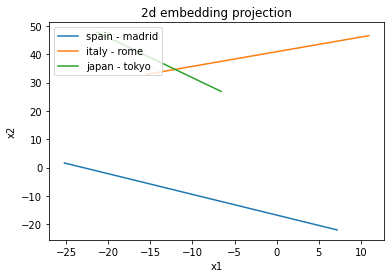

In [26]:
# word pairs provided
female_male = ["men", "women", "king", "queen"]
country_capital = ["spain", "madrid", "italy", "rome", "japan", "tokyo"]
#you may try some other words as well

###################################################
# TODO: Visualize word vectors using TSNE.        #
#                                                 #
###################################################
from sklearn.manifold import TSNE
embeddings = model.layers[1].get_weights()[0]
emb_tsne = TSNE(n_components=2).fit_transform(embeddings)

plt.plot(emb_tsne[np.where(vocabulary == "spain")[0][0]], emb_tsne[np.where(vocabulary == "madrid")[0][0]], label='spain - madrid')
plt.plot(emb_tsne[np.where(vocabulary == "italy")[0][0]], emb_tsne[np.where(vocabulary == "rome")[0][0]], label='italy - rome')
plt.plot(emb_tsne[np.where(vocabulary == "japan")[0][0]], emb_tsne[np.where(vocabulary == "tokyo")[0][0]], label='japan - tokyo')
plt.title('2d embedding projection')
plt.ylabel('x2')
plt.xlabel('x1')
plt.legend(loc="upper left")
plt.show()
###################################################
# END TODO                                        #
###################################################

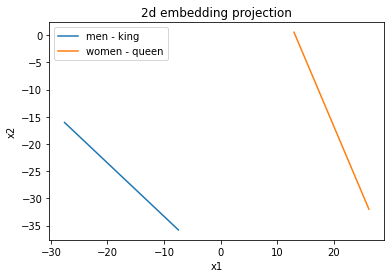

In [25]:
plt.plot(emb_tsne[np.where(vocabulary == "men")[0][0]], emb_tsne[np.where(vocabulary == "king")[0][0]], label='men - king')
plt.plot(emb_tsne[np.where(vocabulary == "women")[0][0]], emb_tsne[np.where(vocabulary == "queen")[0][0]], label='women - queen')
plt.title('2d embedding projection')
plt.ylabel('x2')
plt.xlabel('x1')
plt.legend(loc="upper left")
plt.show()

<font color="red"><strong>Note:</strong></font> Install **sklearn** if you haven't already. 

```
> pip install sklearn
```

In [18]:
model.layers[1].get_weights()

[array([[-0.01519295,  0.04344175,  0.04700555, ...,  0.01208677,
         -0.04032861, -0.00466638],
        [ 0.0050851 ,  0.02196358, -0.01415992, ...,  0.02497489,
         -0.07362664, -0.0028065 ],
        [ 0.02317442,  0.04506389,  0.04521729, ...,  0.05322183,
         -0.17973998,  0.01700845],
        ...,
        [ 0.1989698 ,  0.11043765, -0.23294042, ..., -0.05200608,
          0.22230044, -0.22836402],
        [ 0.24597588,  0.02780934,  0.14276604, ...,  0.29972604,
         -0.05575735, -0.14011434],
        [ 0.13311054, -0.18221721,  0.28743565, ...,  0.04942198,
          0.16795869,  0.1286519 ]], dtype=float32)]

In [24]:
##Solution

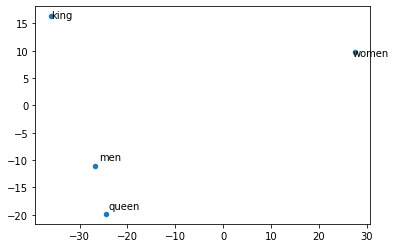

In [20]:
##Solution

vocab_list = list(vocabulary)
sample_words = female_male #["master", "teacher", "student", "graduate", "learning", "teach", "college", "campus"]
indices =[]
for word in sample_words:
  indices.append(vocab_list.index(word))

points = emb_tsne[indices]
plt.scatter(points[:, 0], points[:, 1], 20)

for text, pts in zip(sample_words, points):
    # plt.annotate(text, (X_tsne[idx,0],X_tsne[idx,1]), fontsize=20)
    plt.annotate(text, (int(pts[0]), int(pts[1])))
    